# Ejercicio 12: varianza y sesgo

En este ejercicio consideramos regresión, regresión kernel y k vecinos más cercanos para un ejemplo simple.
¿Qué modelos funcionan mejor para este ejemplo?

In [1]:
%autosave 0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

Autosave disabled


Creamos un conjunto de datos simulado. Puedes cambiar la semilla o la forma de la curva:

In [76]:
np.random.seed(4112)
x_entrena = np.array([1,7,10,0,0,5,9,10, 11, 13,2,4,17,18,1,2])
#x_entrena = np.random.randint(0, 20, 100)
def f(x):
  if x < 10:
    u = 1000*np.sqrt(x)
  else:
    u = 1000*np.sqrt(10)
  return u
y_entrena = np.array(list(map(f, x_entrena))) + 500*np.random.randn(x_entrena.size)
datos_entrena = pd.DataFrame({"x": x_entrena, "y" : y_entrena})
datos_entrena

,x,y
0,1,1553.240369
1,7,2581.118364
2,10,4319.140103
3,0,-882.370952
4,0,222.207659
5,5,2220.347888
6,9,3398.353863
7,10,3698.673952
8,11,2477.930516
9,13,3051.755280


Usaremos tres métodos para hacer predicciones:

In [77]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import kernels
# regresion lineal
modelo_reg = LinearRegression()
# regresión local con kernel 
rbf = kernels.RBF(length_scale = 15.0)
modelo_kernel = KernelRidge(alpha = 0.1, kernel = rbf)
# k vecinos más cercano
modelo_kvmc = KNeighborsRegressor(4, weights = "distance")

Ajustamos los modelos y calculamos predicciones:

In [78]:
# Creamos matriz de entradas: solo hay una en este caso
X_entrena = x_entrena.reshape(-1, 1)
X_entrena.shape


(16, 1)

In [79]:
# ajustamos
ajuste_reg = modelo_reg.fit(X_entrena, y_entrena)
ajuste_kernel = modelo_kernel.fit(X_entrena, y_entrena)
ajuste_kvmc = modelo_kvmc.fit(X_entrena, y_entrena)

Ahora hacemos predicciones:

In [80]:
# Calcular predicciones en datos de prueba
x = np.linspace(0, 20, 100)
X_pred = x.reshape(-1, 1)
preds_reg = ajuste_reg.predict(X_pred)
preds_kernel = ajuste_kernel.predict(X_pred)
preds_kvmc = ajuste_kvmc.predict(X_pred)

In [81]:
df_reg = pd.DataFrame({'x':x, 'y':preds_reg, 'tipo':'reg'})
df_reg

,x,y,tipo
0,0.000000,993.146299,reg
1,0.202020,1030.257938,reg
2,0.404040,1067.369578,reg
3,0.606061,1104.481217,reg
4,0.808081,1141.592856,reg
...,...,...,...
95,19.191919,4518.752032,reg
96,19.393939,4555.863672,reg
97,19.595960,4592.975311,reg
98,19.797980,4630.086950,reg


In [82]:
df_kernel = pd.DataFrame({'x':x, 'y':preds_kernel, 'tipo':'kernel'})
df_kvmc = pd.DataFrame({'x':x, 'y':preds_kvmc, 'tipo':'kvmc'})
ajuste_grafs_df = pd.concat([df_reg, df_kernel, df_kvmc])
ajuste_grafs_df

,x,y,tipo
0,0.000000,993.146299,reg
1,0.202020,1030.257938,reg
2,0.404040,1067.369578,reg
3,0.606061,1104.481217,reg
4,0.808081,1141.592856,reg
...,...,...,...
95,19.191919,3281.072893,kvmc
96,19.393939,3276.146072,kvmc
97,19.595960,3271.175509,kvmc
98,19.797980,3266.278364,kvmc


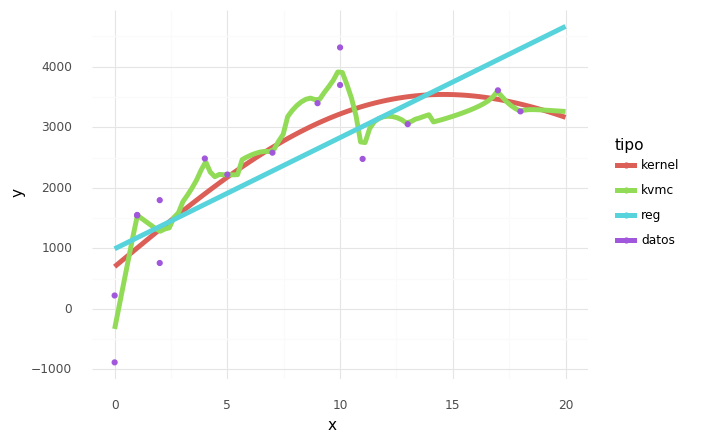

<ggplot: (8775581638625)>

In [83]:
graf_ajustes  = (ggplot(ajuste_grafs_df, aes(x = "x", y= "y", 
  group="tipo", color="tipo")) 
  + geom_line(size = 2) 
  + geom_point(data = datos_entrena.assign(tipo = "datos")) + theme_minimal())
graf_ajustes

Calculamos errores de prueba

In [84]:
from sklearn.metrics import mean_squared_error

X_prueba = np.random.randint(0, 20, 2000).reshape(-1, 1)
y_prueba = np.array(list(map(f, X_prueba[:,0]))) + 500*np.random.randn(X_prueba.shape[0])
datos_prueba = pd.DataFrame(np.column_stack((X_prueba, y_prueba)), columns = ['x', 'y'])
datos_prueba

,x,y
0,4.0,2274.517477
1,2.0,851.333087
2,7.0,2480.202200
3,16.0,3209.107487
4,15.0,3566.662909
...,...,...
1995,13.0,2587.718311
1996,16.0,3134.420796
1997,17.0,2242.339886
1998,12.0,3562.886238


In [85]:
preds_reg = ajuste_reg.predict(X_prueba)
preds_kernel = ajuste_kernel.predict(X_prueba)
preds_kvmc = ajuste_kvmc.predict(X_prueba)

preds_ys = [preds_reg, preds_kernel, preds_kvmc]
ajuste_grafs_dfs = map(lambda x: pd.DataFrame({"x":X_prueba[:,0], "y":x[0],
  "y_obs":y_prueba, "tipo":x[1]}), 
  zip(preds_ys, ["reg", "kernel", "knn"]))
preds_df = pd.concat(list(ajuste_grafs_dfs))
error_prueba = preds_df.groupby("tipo"). \
  apply(lambda df:np.sqrt(mean_squared_error(df.y_obs, df.y)).round(0))
error_prueba.rename("prueba", inplace = True)

tipo
kernel    570.0
knn       622.0
reg       777.0
Name: prueba, dtype: float64

**Preguntas**:

    - Repite usando distintas semillas para cambiar los datos iniciales. ¿Qué diferencias observas?
    - Repite usando una muestra de entrenamiento más grande. ¿Cómo se comparan los métodos?
    - Repite usando una función diferente (f) para generar los datos. Por ejemplo: ¿Qué pasa si es aproximadamente lineal?

# Varianza y sesgo en dimensión alta

Repetimos el ejemplo en dimensión alta. La función que queremos predecir es:

In [104]:
def f(x):
  return np.exp(-8 * np.sum(x**2))
# por ejemplo
f(np.array([0, 0, 0]))
f(np.array([0.1, 0.2, -0.3]))

0.32627979462303947

In [105]:
X = 2*np.random.rand(1000,2) - 1
X.shape

(1000, 2)

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


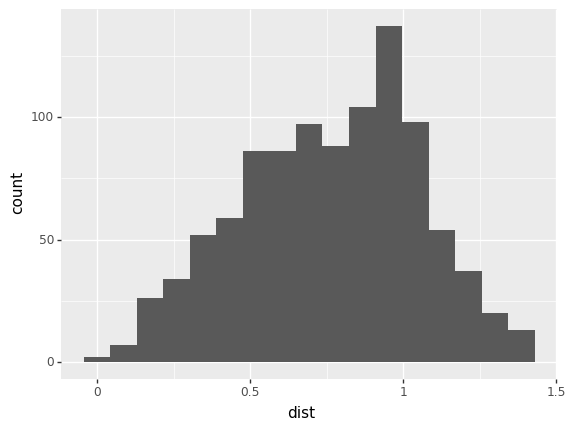

<ggplot: (8775580771378)>

In [106]:
def calc_dist(x):
    return np.sqrt(np.sum(x**2))
distancias = np.apply_along_axis(calc_dist, 1, X)
dist_df = pd.DataFrame({'dist':distancias})
dist_df
(ggplot(dist_df, aes(x='dist')) + geom_histogram())

Calcula el índice del punto mínimo y su valor $f$:

In [114]:
indice = np.argmin(distancias)
indice

647

In [115]:
f(X[indice, :])

0.997872451804543

**Pregunta**: repite en dimensión más alta (por ejemplo 10). ¿Qué pasa con las distancias? ¿Qué tan buena es la predicción del punto más cercano?